# Mini-project on Wine Quality

---

## 1. Problem Definition



What physicochemical factors affect the quality of wine and how do they do so.

---

## 2. Dataset Preview


In [80]:
# Basic Libraries
import os
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot 

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import IsolationForest

sb.set() # set the default Seaborn style for graphics

In [81]:
data = pd.read_csv('winequalityN.csv')
data.head()

type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0  white            7.0              0.27         0.36            20.7   
1  white            6.3              0.30         0.34             1.6   
2  white            8.1              0.28         0.40             6.9   
3  white            7.2              0.23         0.32             8.5   
4  white            7.2              0.23         0.32             8.5   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.045                 45.0                 170.0   1.0010  3.00   
1      0.049                 14.0                 132.0   0.9940  3.30   
2      0.050                 30.0                  97.0   0.9951  3.26   
3      0.058                 47.0                 186.0   0.9956  3.19   
4      0.058                 47.0                 186.0   0.9956  3.19   

   sulphates  alcohol  quality  
0       0.45      8.8        6  
1       0.49      9.5        6  
2       0.44     10.1        6  
3       0.40      9.9        6  
4       0.40      9.9        6

In [82]:
data.describe()

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    6487.000000       6489.000000  6494.000000     6495.000000   
mean        7.216579          0.339691     0.318722        5.444326   
std         1.296750          0.164649     0.145265        4.758125   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.250000        1.800000   
50%         7.000000          0.290000     0.310000        3.000000   
75%         7.700000          0.400000     0.390000        8.100000   
max        15.900000          1.580000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  6495.000000          6497.000000           6497.000000  6497.000000   
mean      0.056042            30.525319            115.744574     0.994697   
std       0.035036            17.749400             56.521855     0.002999   
min       0.009000             1.000000              6.000000     0.987110   
25%       0.038000            17.000000             77.000000     0.992340   
50%       0.047000            29.000000            118.000000     0.994890   
75%       0.065000            41.000000            156.000000     0.996990   
max       0.611000           289.000000            440.000000     1.038980   

                pH    sulphates      alcohol      quality  
count  6488.000000  6493.000000  6497.000000  6497.000000  
mean      3.218395     0.531215    10.491801     5.818378  
std       0.160748     0.148814     1.192712     0.873255  
min       2.720000     0.220000     8.000000     3.000000  
25%       3.110000     0.430000     9.500000     5.000000  
50%       3.210000     0.510000    10.300000     6.000000  
75%       3.320000     0.600000    11.300000     6.000000  
max       4.010000     2.000000    14.900000     9.000000

 #### The counts of each variable is not the same as there are some NULL values. 

## 3. Data Cleaning

In [63]:
data.isnull().sum()

def get_missing_data(dataFrame):
    percent_missing = dataFrame.isnull().sum() * 100 / len(dataFrame)
    missing_value_df = pd.DataFrame({'percentage missing': round(percent_missing,3)})
    missing_value_df["percentage missing"] = missing_value_df["percentage missing"].astype(str)
    return missing_value_df

missing_values_df = get_missing_data(data)
print(missing_values_df+'%')

                     percentage missing
type                               0.0%
fixed acidity                    0.154%
volatile acidity                 0.123%
citric acid                      0.046%
residual sugar                   0.031%
chlorides                        0.031%
free sulfur dioxide                0.0%
total sulfur dioxide               0.0%
density                            0.0%
pH                               0.139%
sulphates                        0.062%
alcohol                            0.0%
quality                            0.0%


#### Since the percentage of missing datapoints is extremely low, we proceed to remove all rows of data with missing values.

In [95]:
data = data.dropna()
print(data.count())
uncleaned_data = data

type                    6463
fixed acidity           6463
volatile acidity        6463
citric acid             6463
residual sugar          6463
chlorides               6463
free sulfur dioxide     6463
total sulfur dioxide    6463
density                 6463
pH                      6463
sulphates               6463
alcohol                 6463
quality                 6463
dtype: int64


#### We are left with 6463 rows of data in **`df_wine`**

In [65]:
wine_red = data[data["type"] == "red"].copy()
wine_white = data[data["type"] == "white"].copy()

In [66]:
red_wine_stats = pd.DataFrame({"Red Wine Stats" : wine_red.describe().loc["mean"]})
white_wine_stats = pd.DataFrame({"White Wine Stats" : wine_white.describe().loc["mean"]})
wine_stats = red_wine_stats.merge(white_wine_stats, on = red_wine_stats.index)
wine_stats

key_0  Red Wine Stats  White Wine Stats
0          fixed acidity        8.326365          6.855123
1       volatile acidity        0.527659          0.278071
2            citric acid        0.271551          0.334199
3         residual sugar        2.538512          6.394343
4              chlorides        0.087497          0.045771
5    free sulfur dioxide       15.841808         35.317146
6   total sulfur dioxide       46.463905        138.340144
7                density        0.996752          0.994026
8                     pH        3.310590          3.188154
9              sulphates        0.657866          0.489700
10               alcohol       10.419617         10.516772
11               quality        5.636535          5.878029

#### Comparing the statistical distribution of red wine and white wine, we see that there is a marked difference for some of the independent variables.

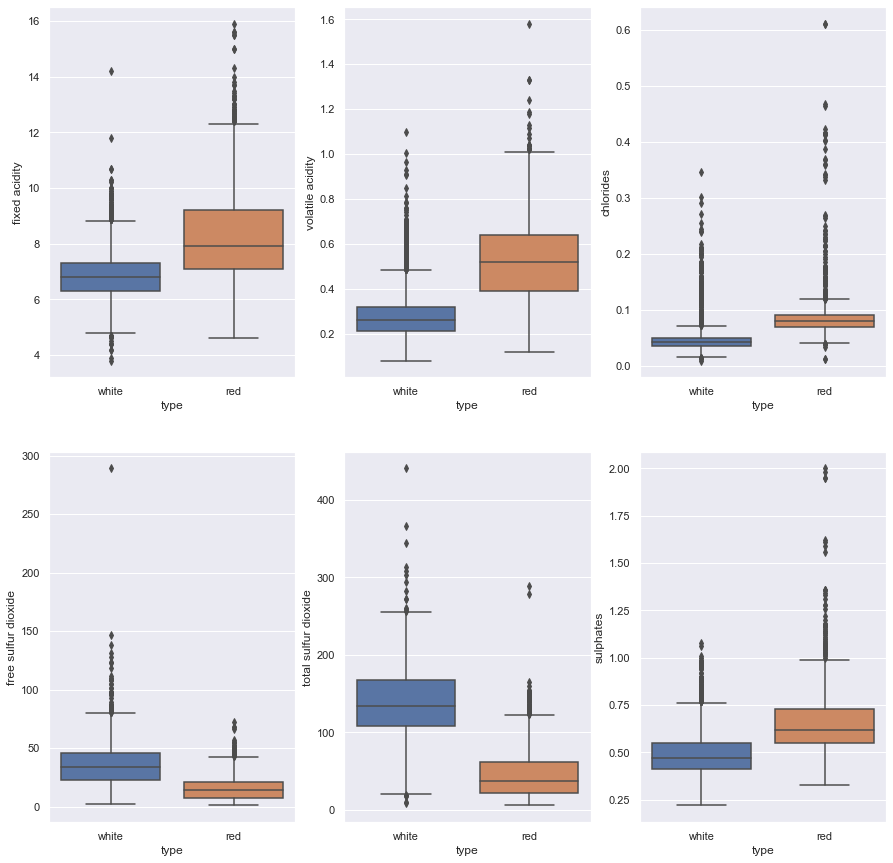

In [77]:
features = ['fixed acidity', 'volatile acidity', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'sulphates']
fig, axes = plt.subplots(2, 3, figsize=(15,15))
for i, ax in enumerate(axes.flat):
    sb.boxplot(data = data, y = features[i], x = 'type', ax = ax)

#### Since the distributions vary quite a lot between red and white wines for quite a few of the features, we decided to visualise the trends in red and white wine individually.

In [78]:
wine_white

type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0     white            7.0              0.27         0.36            20.7   
1     white            6.3              0.30         0.34             1.6   
2     white            8.1              0.28         0.40             6.9   
3     white            7.2              0.23         0.32             8.5   
4     white            7.2              0.23         0.32             8.5   
...     ...            ...               ...          ...             ...   
4891  white            5.7              0.21         0.32             0.9   
4893  white            6.2              0.21         0.29             1.6   
4894  white            6.6              0.32         0.36             8.0   
4896  white            5.5              0.29         0.30             1.1   
4897  white            6.0              0.21         0.38             0.8   

      chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0         0.045                 45.0                 170.0  1.00100  3.00   
1         0.049                 14.0                 132.0  0.99400  3.30   
2         0.050                 30.0                  97.0  0.99510  3.26   
3         0.058                 47.0                 186.0  0.99560  3.19   
4         0.058                 47.0                 186.0  0.99560  3.19   
...         ...                  ...                   ...      ...   ...   
4891      0.038                 38.0                 121.0  0.99074  3.24   
4893      0.039                 24.0                  92.0  0.99114  3.27   
4894      0.047                 57.0                 168.0  0.99490  3.15   
4896      0.022                 20.0                 110.0  0.98869  3.34   
4897      0.020                 22.0                  98.0  0.98941  3.26   

      sulphates  alcohol  quality  
0          0.45      8.8        6  
1          0.49      9.5        6  
2          0.44     10.1        6  
3          0.40      9.9        6  
4          0.40      9.9        6  
...         ...      ...      ...  
4891       0.46     10.6        6  
4893       0.50     11.2        6  
4894       0.46      9.6        5  
4896       0.38     12.8        7  
4897       0.32     11.8        6  

[4870 rows x 13 columns]

#### After splitting the data, white wine has 4870 rows of data

In [79]:
wine_red

type  fixed acidity  volatile acidity  citric acid  residual sugar  \
4898  red            7.4             0.700         0.00             1.9   
4899  red            7.8             0.880         0.00             2.6   
4900  red            7.8             0.760         0.04             2.3   
4901  red           11.2             0.280         0.56             1.9   
4902  red            7.4             0.700         0.00             1.9   
...   ...            ...               ...          ...             ...   
6491  red            6.8             0.620         0.08             1.9   
6492  red            6.2             0.600         0.08             2.0   
6494  red            6.3             0.510         0.13             2.3   
6495  red            5.9             0.645         0.12             2.0   
6496  red            6.0             0.310         0.47             3.6   

      chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
4898      0.076                 11.0                  34.0  0.99780  3.51   
4899      0.098                 25.0                  67.0  0.99680  3.20   
4900      0.092                 15.0                  54.0  0.99700  3.26   
4901      0.075                 17.0                  60.0  0.99800  3.16   
4902      0.076                 11.0                  34.0  0.99780  3.51   
...         ...                  ...                   ...      ...   ...   
6491      0.068                 28.0                  38.0  0.99651  3.42   
6492      0.090                 32.0                  44.0  0.99490  3.45   
6494      0.076                 29.0                  40.0  0.99574  3.42   
6495      0.075                 32.0                  44.0  0.99547  3.57   
6496      0.067                 18.0                  42.0  0.99549  3.39   

      sulphates  alcohol  quality  
4898       0.56      9.4        5  
4899       0.68      9.8        5  
4900       0.65      9.8        5  
4901       0.58      9.8        6  
4902       0.56      9.4        5  
...         ...      ...      ...  
6491       0.82      9.5        6  
6492       0.58     10.5        5  
6494       0.75     11.0        6  
6495       0.71     10.2        5  
6496       0.66     11.0        6  

[1593 rows x 13 columns]

#### On the other hand, red wine has 1593 rows of data

<AxesSubplot:xlabel='type', ylabel='count'>

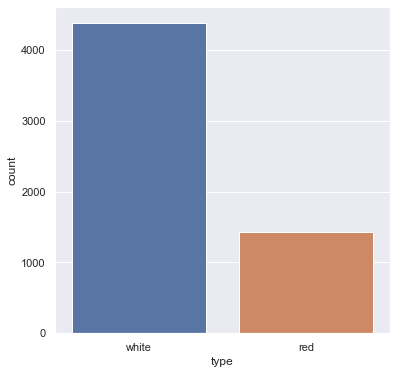

In [83]:
sb.set(rc={'figure.figsize':(6,6)})
sb.countplot(data = cleaned_df, x = 'type')

#### We see that the dataset is imbalanced as the proportion of white wine datapoints in the dataset is much greater than that of red wine. This does not present too big a challenge in our analysis but we have to keep in mind that the data for red wine only constitutes about 20% of the total dataset.

# 3. Data Visualisation

In [96]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6463 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6463 non-null   object 
 1   fixed acidity         6463 non-null   float64
 2   volatile acidity      6463 non-null   float64
 3   citric acid           6463 non-null   float64
 4   residual sugar        6463 non-null   float64
 5   chlorides             6463 non-null   float64
 6   free sulfur dioxide   6463 non-null   float64
 7   total sulfur dioxide  6463 non-null   float64
 8   density               6463 non-null   float64
 9   pH                    6463 non-null   float64
 10  sulphates             6463 non-null   float64
 11  alcohol               6463 non-null   float64
 12  quality               6463 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 706.9+ KB


#### The data types of all the independent variables have Dtype **`float64`** while quality has Dtype **`int64`**

In [97]:
wine_red = cleaned_df[cleaned_df["type"] == "red"].copy()
wine_white = cleaned_df[cleaned_df["type"] == "white"].copy()

red_wine_stats = pd.DataFrame({"Red Wine Stats" : wine_red.describe().loc["mean"]})

In [98]:
white_wine_stats = pd.DataFrame({"White Wine Stats" : wine_white.describe().loc["mean"]})
red_wine_stats = red_wine_stats.merge(white_wine_stats, on = red_wine_stats.index)

In [101]:
red_wine_stats['pct_change'] = ((red_wine_stats[['Red Wine Stats', 'White Wine Stats']].pct_change(axis=1)['White Wine Stats'])* 100).round(2).map(str) + '%'
red_wine_stats

key_0  Red Wine Stats  White Wine Stats pct_change
0          fixed acidity        8.272435          6.850924    -17.18%
1       volatile acidity        0.527659          0.270742    -48.69%
2            citric acid        0.258828          0.328319     26.85%
3         residual sugar        2.390614          6.102794    155.28%
4              chlorides        0.082181          0.044063    -46.38%
5    free sulfur dioxide       15.024773         34.691036    130.89%
6   total sulfur dioxide       43.345429        136.916857    215.87%
7                density        0.996720          0.993856     -0.29%
8                     pH        3.317732          3.188750     -3.89%
9              sulphates        0.639812          0.485226    -24.16%
10               alcohol       10.377134         10.548577      1.65%
11               quality        5.625960          5.911040      5.07%

#### Comparing between the statistics for red wine and white wine, we see that white wine has significantly lower levels of **`volatile acidity`**, **`chlorides`** and **`sulphates`**, while it has significantly **`higher residual sugar`**, **`free sulfur dioxide`** and **`total sulfur dioxide`**.

---

#### Lets try to find out which properties of the wine affect the quality more significantly. We do this through 2 correlation matrices, one for each type of wine. First, we start with white wine.

<AxesSubplot:>

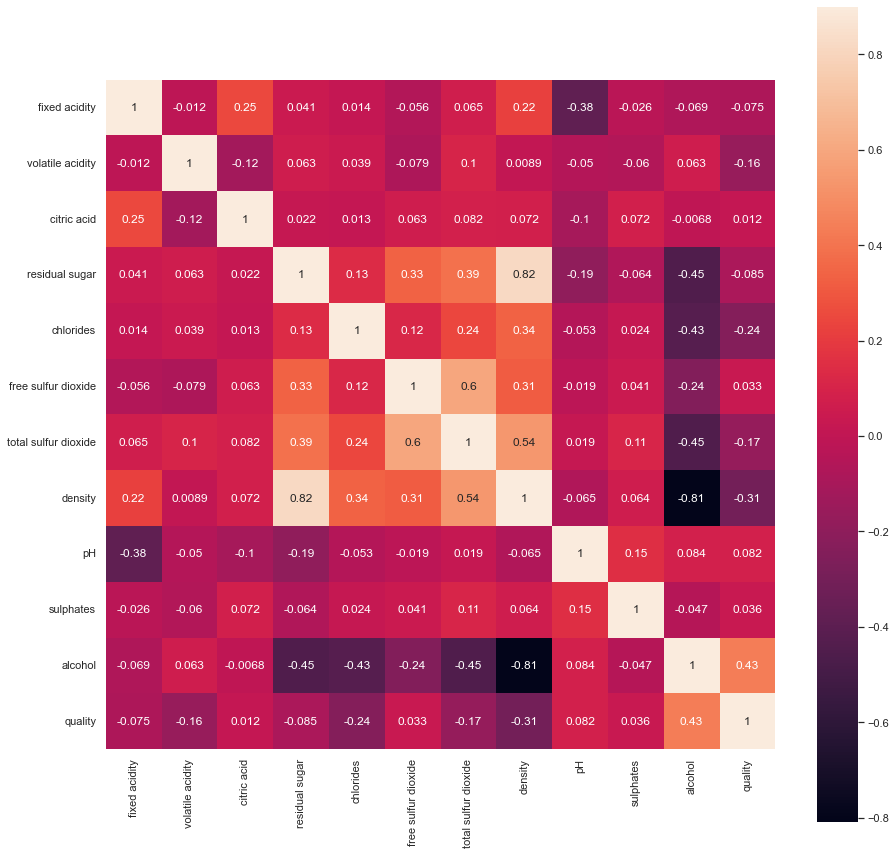

In [104]:
corMat = wine_white.corr()
fig, ax = plt.subplots(figsize=(15,15))  
sb.heatmap(corMat, vmax=0.9, square = True, annot=True, ax = ax)

#### For white wine, **`density`** and **`level of chlorides`** has the strongest negative correlation with **`quality`**, whereas **`alcohol`** is the only property with strong positive correlation with **`quality`**.

<AxesSubplot:>

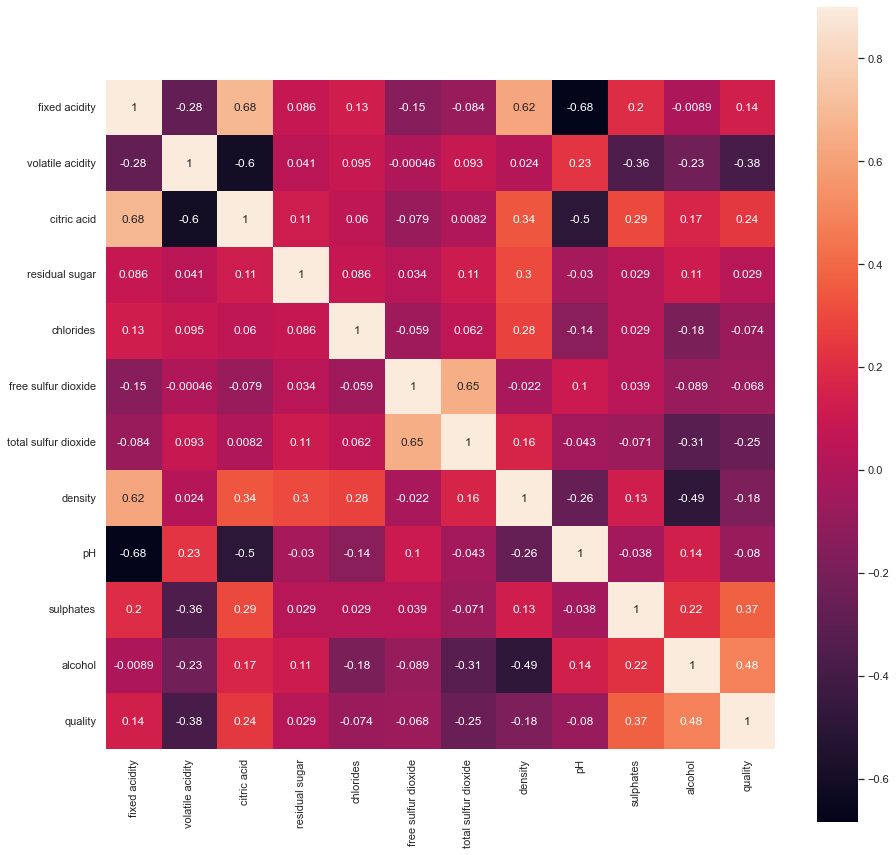

In [106]:
corMat = wine_red.corr()
fig, ax = plt.subplots(figsize=(15,15))  
sb.heatmap(corMat, vmax=0.9, square = True, annot=True, ax = ax)

#### For red wine, **`volatile acidity`** and **`total sulfur dioxide`** has the strongest negative correlation with **`quality`**, while **`alcohol`** and **`sulphates`** have the strongest positive correlation with **`quality`**.

---

#### Next, we look at how the data for the properties of each type of wine is distributed and also find out their level skewness. We first make the data colours match the colour of the wines.

In [107]:
colours = ["#d4c52d", "#bf081d"]
sb.set_palette(sb.color_palette(colours))

Feature fixed acidity has skewness 1.571593058906993
Feature volatile acidity has skewness 1.4751169622600009
Feature citric acid has skewness 0.1573551253303913
Feature residual sugar has skewness 1.115608675233017
Feature chlorides has skewness 2.33182448373063
Feature free sulfur dioxide has skewness 0.5618080249473225
Feature total sulfur dioxide has skewness -0.09788753124195072
Feature density has skewness -0.09492224439465599
Feature pH has skewness 0.32829634225399035
Feature sulphates has skewness 1.0314872398907875
Feature alcohol has skewness 0.509845260551625
Feature quality has skewness 0.23675972004380985


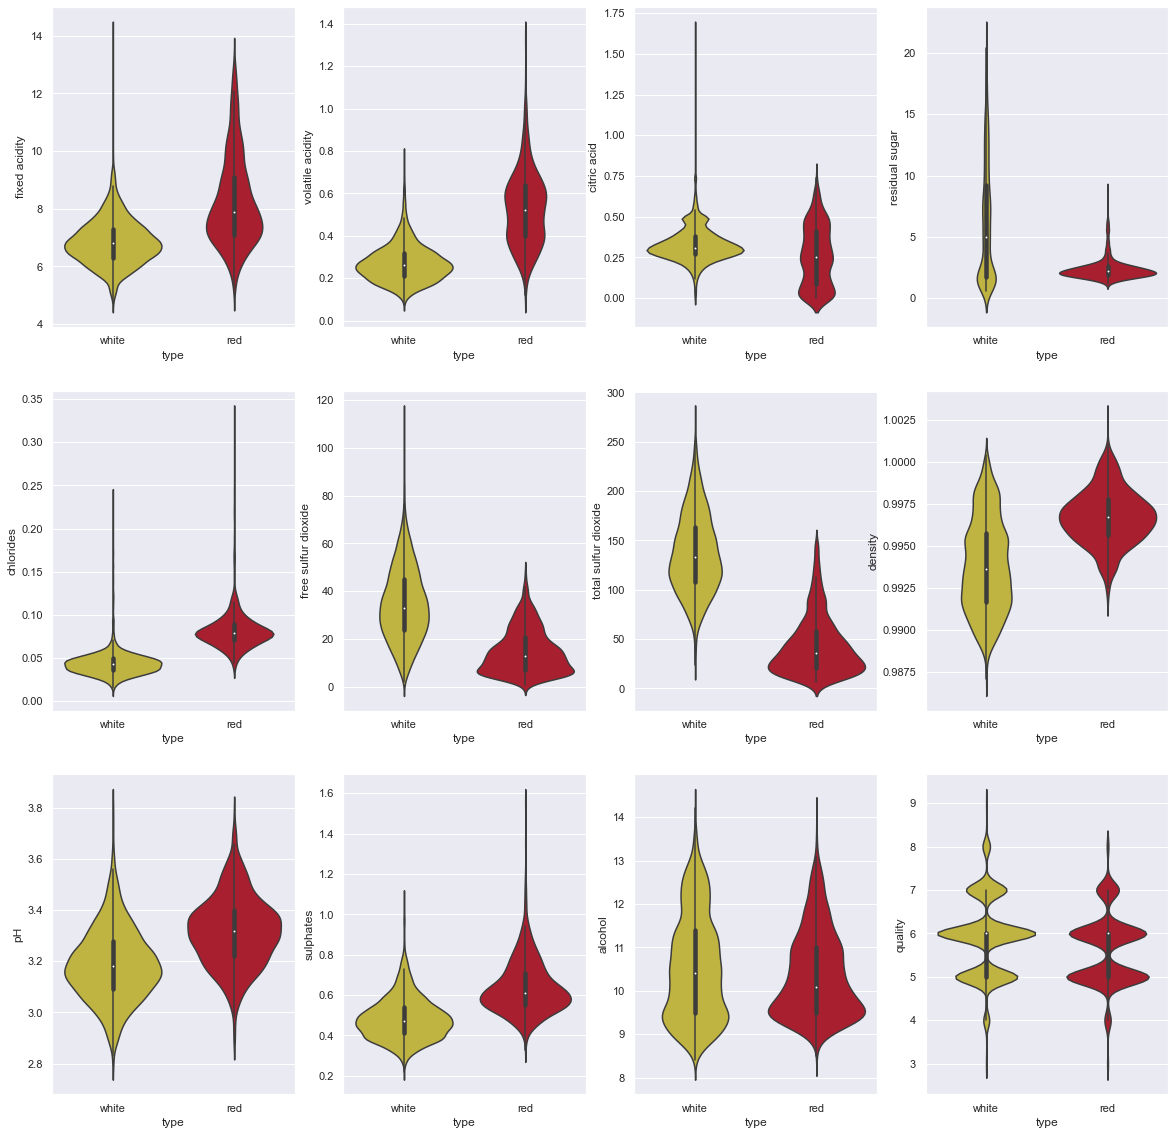

In [108]:
from scipy.stats import skew

features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 
            'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']

fig, axes = plt.subplots(3, 4, figsize=(20,20))

for i, ax in enumerate(axes.flat):
    sb.violinplot(data = cleaned_df, y = features[i], x = 'type', ax = ax)
    

    sk = skew(cleaned_df[features[i]])

    print("Feature {} has skewness {}".format(features[i], sk))

#### We further categorise the red wine and white wine quality into Low (quality 3 or 4), Medium (quality 5, 6 or 7) and High (quality 8 or 9) so that we can more clearly see trends of the wine properties across the different levels of quality.

In [109]:
def wineQuality(x):

  if x < 5 :
    label = 'Low'
  elif x > 4 and x < 7:
    label = 'Medium'
  else:
    label = "High"

  return label

<AxesSubplot:xlabel='quality', ylabel='count'>

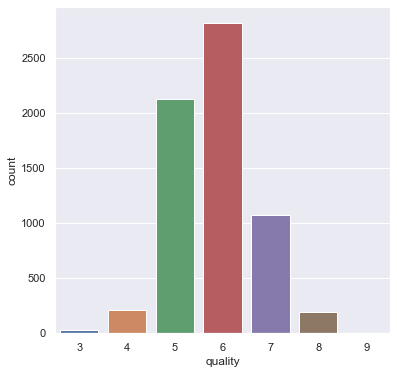

In [127]:
sb.set(rc={'figure.figsize':(6,6)})
sb.countplot(data = data, x = 'quality')

#### Based on the distribution above, we group qualities 3, 4 and 5 together as **`Low`**, quality 6 as **`Medium`** and qualities 7, 8 and 9 as **`High`**.

In [112]:
data['Quality Level'] = pd.cut(data['quality'], bins=[0, 5, 6, 9], labels=['Low', 'Medium', 'High'])

In [113]:
data.head()

type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0  white            7.0              0.27         0.36            20.7   
1  white            6.3              0.30         0.34             1.6   
2  white            8.1              0.28         0.40             6.9   
3  white            7.2              0.23         0.32             8.5   
4  white            7.2              0.23         0.32             8.5   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.045                 45.0                 170.0   1.0010  3.00   
1      0.049                 14.0                 132.0   0.9940  3.30   
2      0.050                 30.0                  97.0   0.9951  3.26   
3      0.058                 47.0                 186.0   0.9956  3.19   
4      0.058                 47.0                 186.0   0.9956  3.19   

   sulphates  alcohol  quality Quality Level  
0       0.45      8.8        6        Medium  
1       0.49      9.5        6        Medium  
2       0.44     10.1        6        Medium  
3       0.40      9.9        6        Medium  
4       0.40      9.9        6        Medium

<AxesSubplot:xlabel='Quality Level', ylabel='count'>

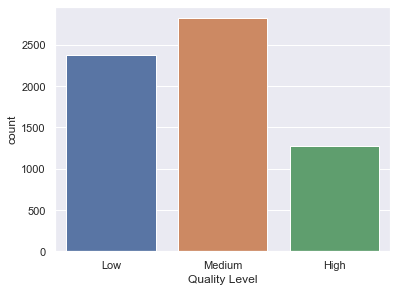

In [128]:
sb.set(rc={'figure.figsize':(6,4.5)})
sb.countplot(data = data, x = 'Quality Level')

#### Next, we shall perform visualisation on the independent variables.

### Alcohol level and wine quality

<AxesSubplot:xlabel='quality', ylabel='alcohol'>

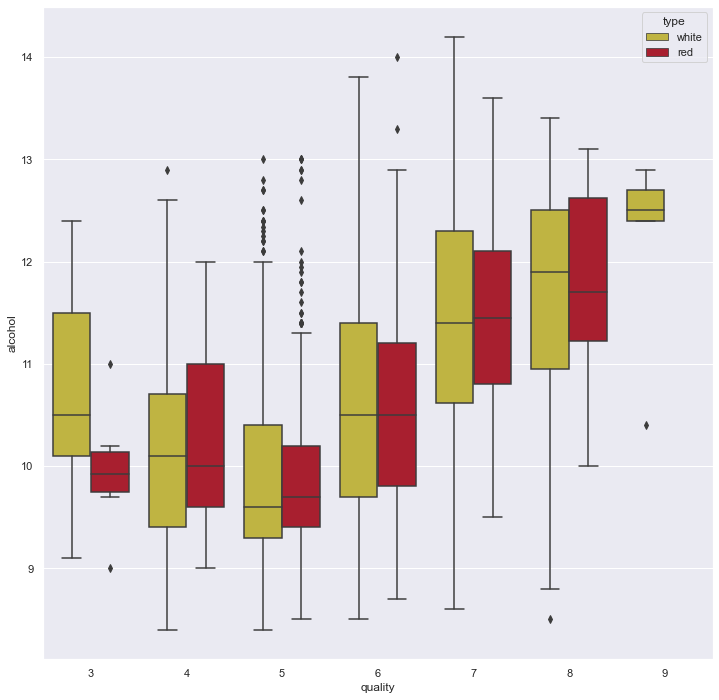

In [130]:
fig, ax = plt.subplots(figsize=(12,12))  

colours = ["#d4c52d", "#bf081d"]
sb.set_palette(sb.color_palette(colours))

sb.boxplot(data = cleaned_df, x = "quality", y = "alcohol" , hue = "type", ax = ax)

 
### Fixed acidity and pH

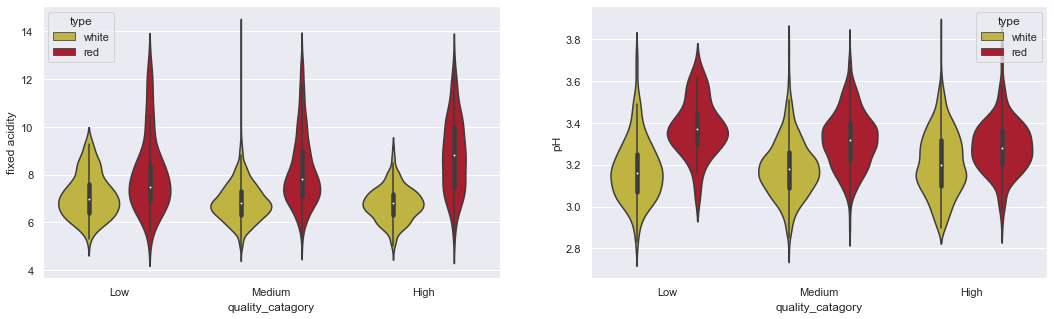

In [131]:
wine_df_viz = cleaned_df.copy()


wine_df_viz["quality_catagory"] = cleaned_df["quality"].apply(wineQuality)
features_violin = ['fixed acidity', 'pH']
fig_2, axes_2 = plt.subplots(1, 2, figsize=(18,5))
x_order= ["Low", "Medium", "High"]

for i, ax in enumerate(axes_2.flat):
    
    if i == len(features_violin):
        break

    sb.violinplot(data = wine_df_viz, y = features_violin[i], x = 'quality_catagory',hue = 'type', ax = ax, order =x_order)

#### Grapes are the main contributor to the level of fixed acidity. Cool climate grapes give high acidity and results in a more sour taste and warm climate grapes give less acidity.

#### For both types of wine and across the wine quality bins, the fixed acidity is spread out around a value of 7 to 8.  The pH also does not vary much across different wine quality.

---

### Volatile acidity and citric acid

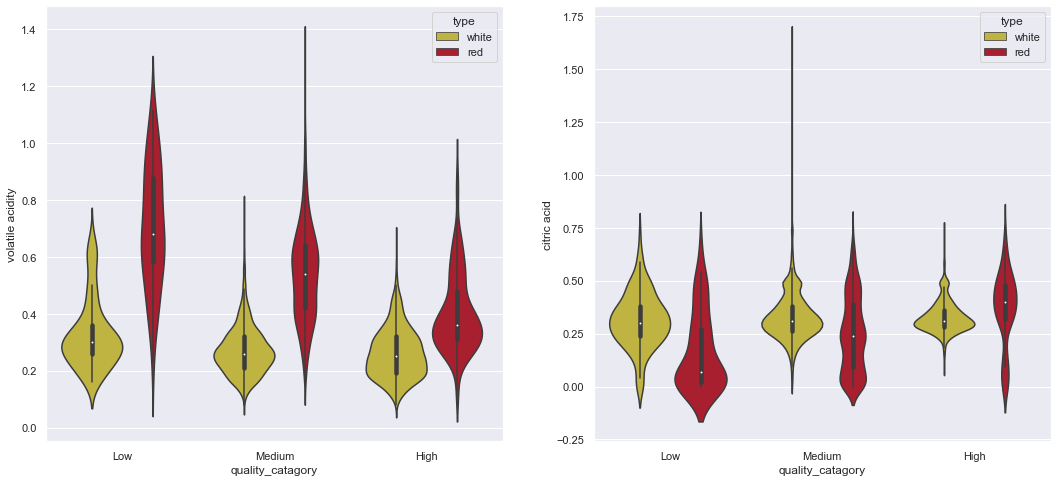

In [151]:
wine_df_viz["quality_catagory"] = cleaned_df["quality"].apply(wineQuality)

features_violin = ['volatile acidity', 'citric acid']
fig_2, axes_2 = plt.subplots(1, 2, figsize=(18,8))
x_order= ["Low", "Medium", "High"]

for i, ax in enumerate(axes_2.flat):
    
    if i == len(features_violin):
        break

    sb.violinplot(data = wine_df_viz, y = features_violin[i], x = 'quality_catagory',hue = 'type', ax = ax, order =x_order)

#### Volatile acidity is distilled out from the wine as too much of it can lead to undesirable taste hence we can see more of its presence in lower quality wine. For white wine there isn’t much change in the quality.

#### Citric acid is added separately to give the wine more freshness, we can see the effect of higher citric acid on red wine leading to better quality. But in white wine we don’t see much difference.

---

### Residual sugar and quality

<AxesSubplot:xlabel='Quality Level', ylabel='residual sugar'>

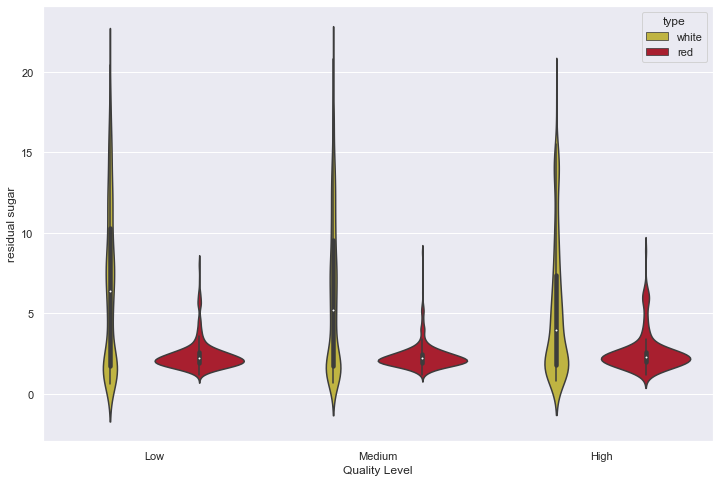

In [140]:
wine_df_viz["quality_catagory"] = cleaned_df["quality"].apply(wineQuality)

fig_2, axes_2 = plt.subplots(1, 1, figsize=(12,8))
x_order= ["Low", "Medium", "High"]


sb.violinplot(data = wine_df_viz, y = 'residual sugar', x = 'Quality Level',hue = 'type', order =x_order)

#### Here, we see that residual sugar does not have an apparant effect on the overall wine quality

<AxesSubplot:xlabel='Quality Level', ylabel='alcohol'>

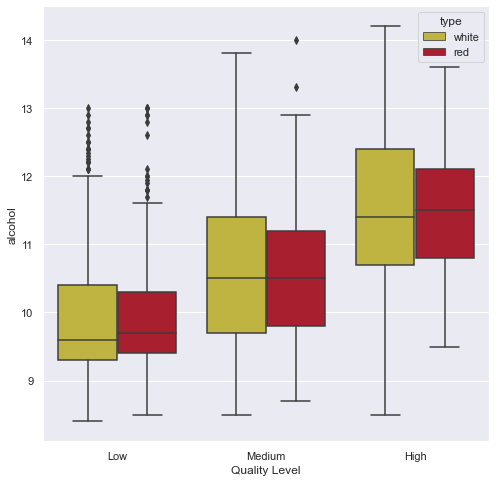

In [152]:
fig, ax = plt.subplots(1,1,figsize=(8,8))  

colours = ["#d4c52d", "#bf081d"]
sb.set_palette(sb.color_palette(colours))

sb.boxplot(data = cleaned_df, x = "Quality Level", y = "alcohol" , hue = "type", ax = ax)

#### Alcohol level does not have a general trend when compared with quality, but it is interesting to note that the alcohol level of wine dips from quality 3 to 5 and rises sharply from 5 to 9.

<AxesSubplot:xlabel='alcohol', ylabel='density'>

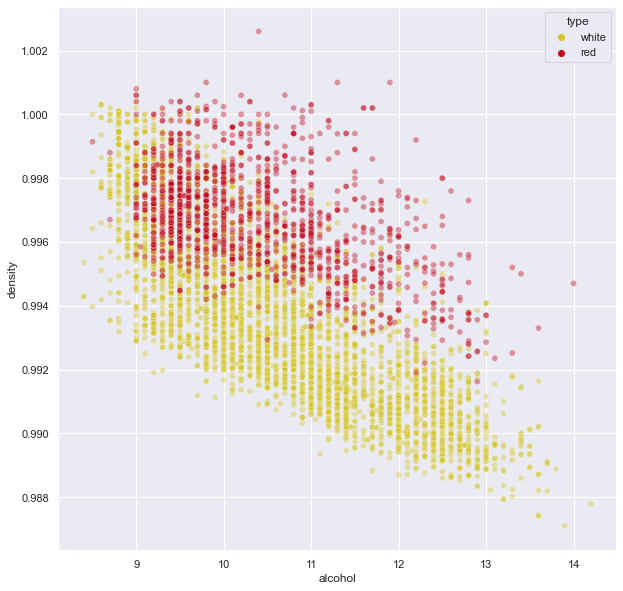

In [142]:
plt.figure(figsize=(10, 10))
sb.scatterplot(data = wine_df_viz, x = "alcohol", y = "density", hue = "type", alpha=0.4)

#### We can see from above that the correlation with density and alcohol is same for both types of wine, the major difference is that red wine has higher density compared to white wine.

<AxesSubplot:xlabel='quality_catagory', ylabel='total sulfur dioxide'>

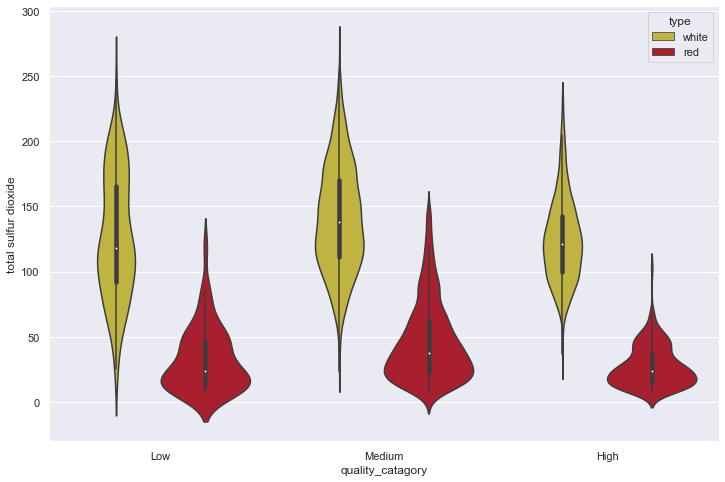

In [143]:
wine_df_viz["quality_catagory"] = cleaned_df["quality"].apply(wineQuality)

fig_2, axes_2 = plt.subplots(1, 1, figsize=(12,8))
x_order= ["Low", "Medium", "High"]

sb.violinplot(data = wine_df_viz, y = 'total sulfur dioxide', x = 'quality_catagory',hue = 'type', order =x_order)

#### Sulphur dioxide kills bacteria. Too much sulphur dioxide can kill the good yeast and give an undesirable odour So basically the least amount of sulphur dioxide without making the wine pungent will give us a good wine. We can observe that sulfur dioxide plays a bigger role for white wine rather than red.

---

# 3. Data Cleaning

#### We used an Isolation Forest to get rid of the outliers of red wine and white wine individually.

In [153]:
rng = np.random.RandomState(42)
model = IsolationForest(contamination=float(0.1),random_state=42)

anomaly_inputs = ['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide','total sulfur dioxide','density','pH', 'sulphates','alcohol']
model.fit(wine_white[anomaly_inputs].values)

IsolationForest(contamination=0.1, random_state=42)

In [154]:
print(model.get_params())

wine_white['anomaly_scores'] = model.decision_function(wine_white[anomaly_inputs].values)
wine_white['anomaly'] = model.predict(wine_white[anomaly_inputs].values)

{'bootstrap': False, 'contamination': 0.1, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 100, 'n_jobs': None, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [155]:
def outlier_plot(data, outlier_method_name, x_var, y_var, 
                 xaxis_limits=[0,1], yaxis_limits=[0,1]):
    
    print(f'Outlier Method: {outlier_method_name}')
    
    # Create a dynamic title based on the method
    method = f'{outlier_method_name}_anomaly'
    
    # Print out key statistics
    print(f"Number of anomalous values {len(data[data['anomaly']==-1])}")
    print(f"Number of non anomalous values  {len(data[data['anomaly']== 1])}")
    print(f'Total Number of Values: {len(data)}')
    
    # Create the chart using seaborn
    g = sb.FacetGrid(data, col='anomaly', height=4, hue='anomaly', hue_order=[1,-1])
    g.map(sb.scatterplot, x_var, y_var)
    g.fig.suptitle(f'Outlier Method: {outlier_method_name}', y=1.10, fontweight='bold')
    g.set(xlim=xaxis_limits, ylim=yaxis_limits)
    axes = g.axes.flatten()
    axes[0].set_title(f"Outliers\n{len(data[data['anomaly']== -1])} points")
    axes[1].set_title(f"Inliers\n {len(data[data['anomaly']==  1])} points")
    return 

Outlier Method: Isolation Forest
Number of anomalous values 438
Number of non anomalous values  3946
Total Number of Values: 4384


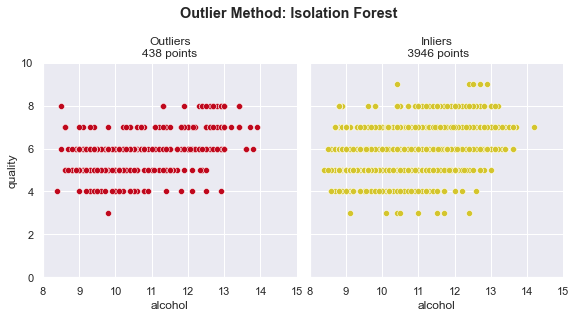

In [156]:
outlier_plot(wine_white, 'Isolation Forest', 'alcohol', 'quality', [8, 15], [0, 10]);

#### The left plot shows the outliers removed from white wine dataframe.

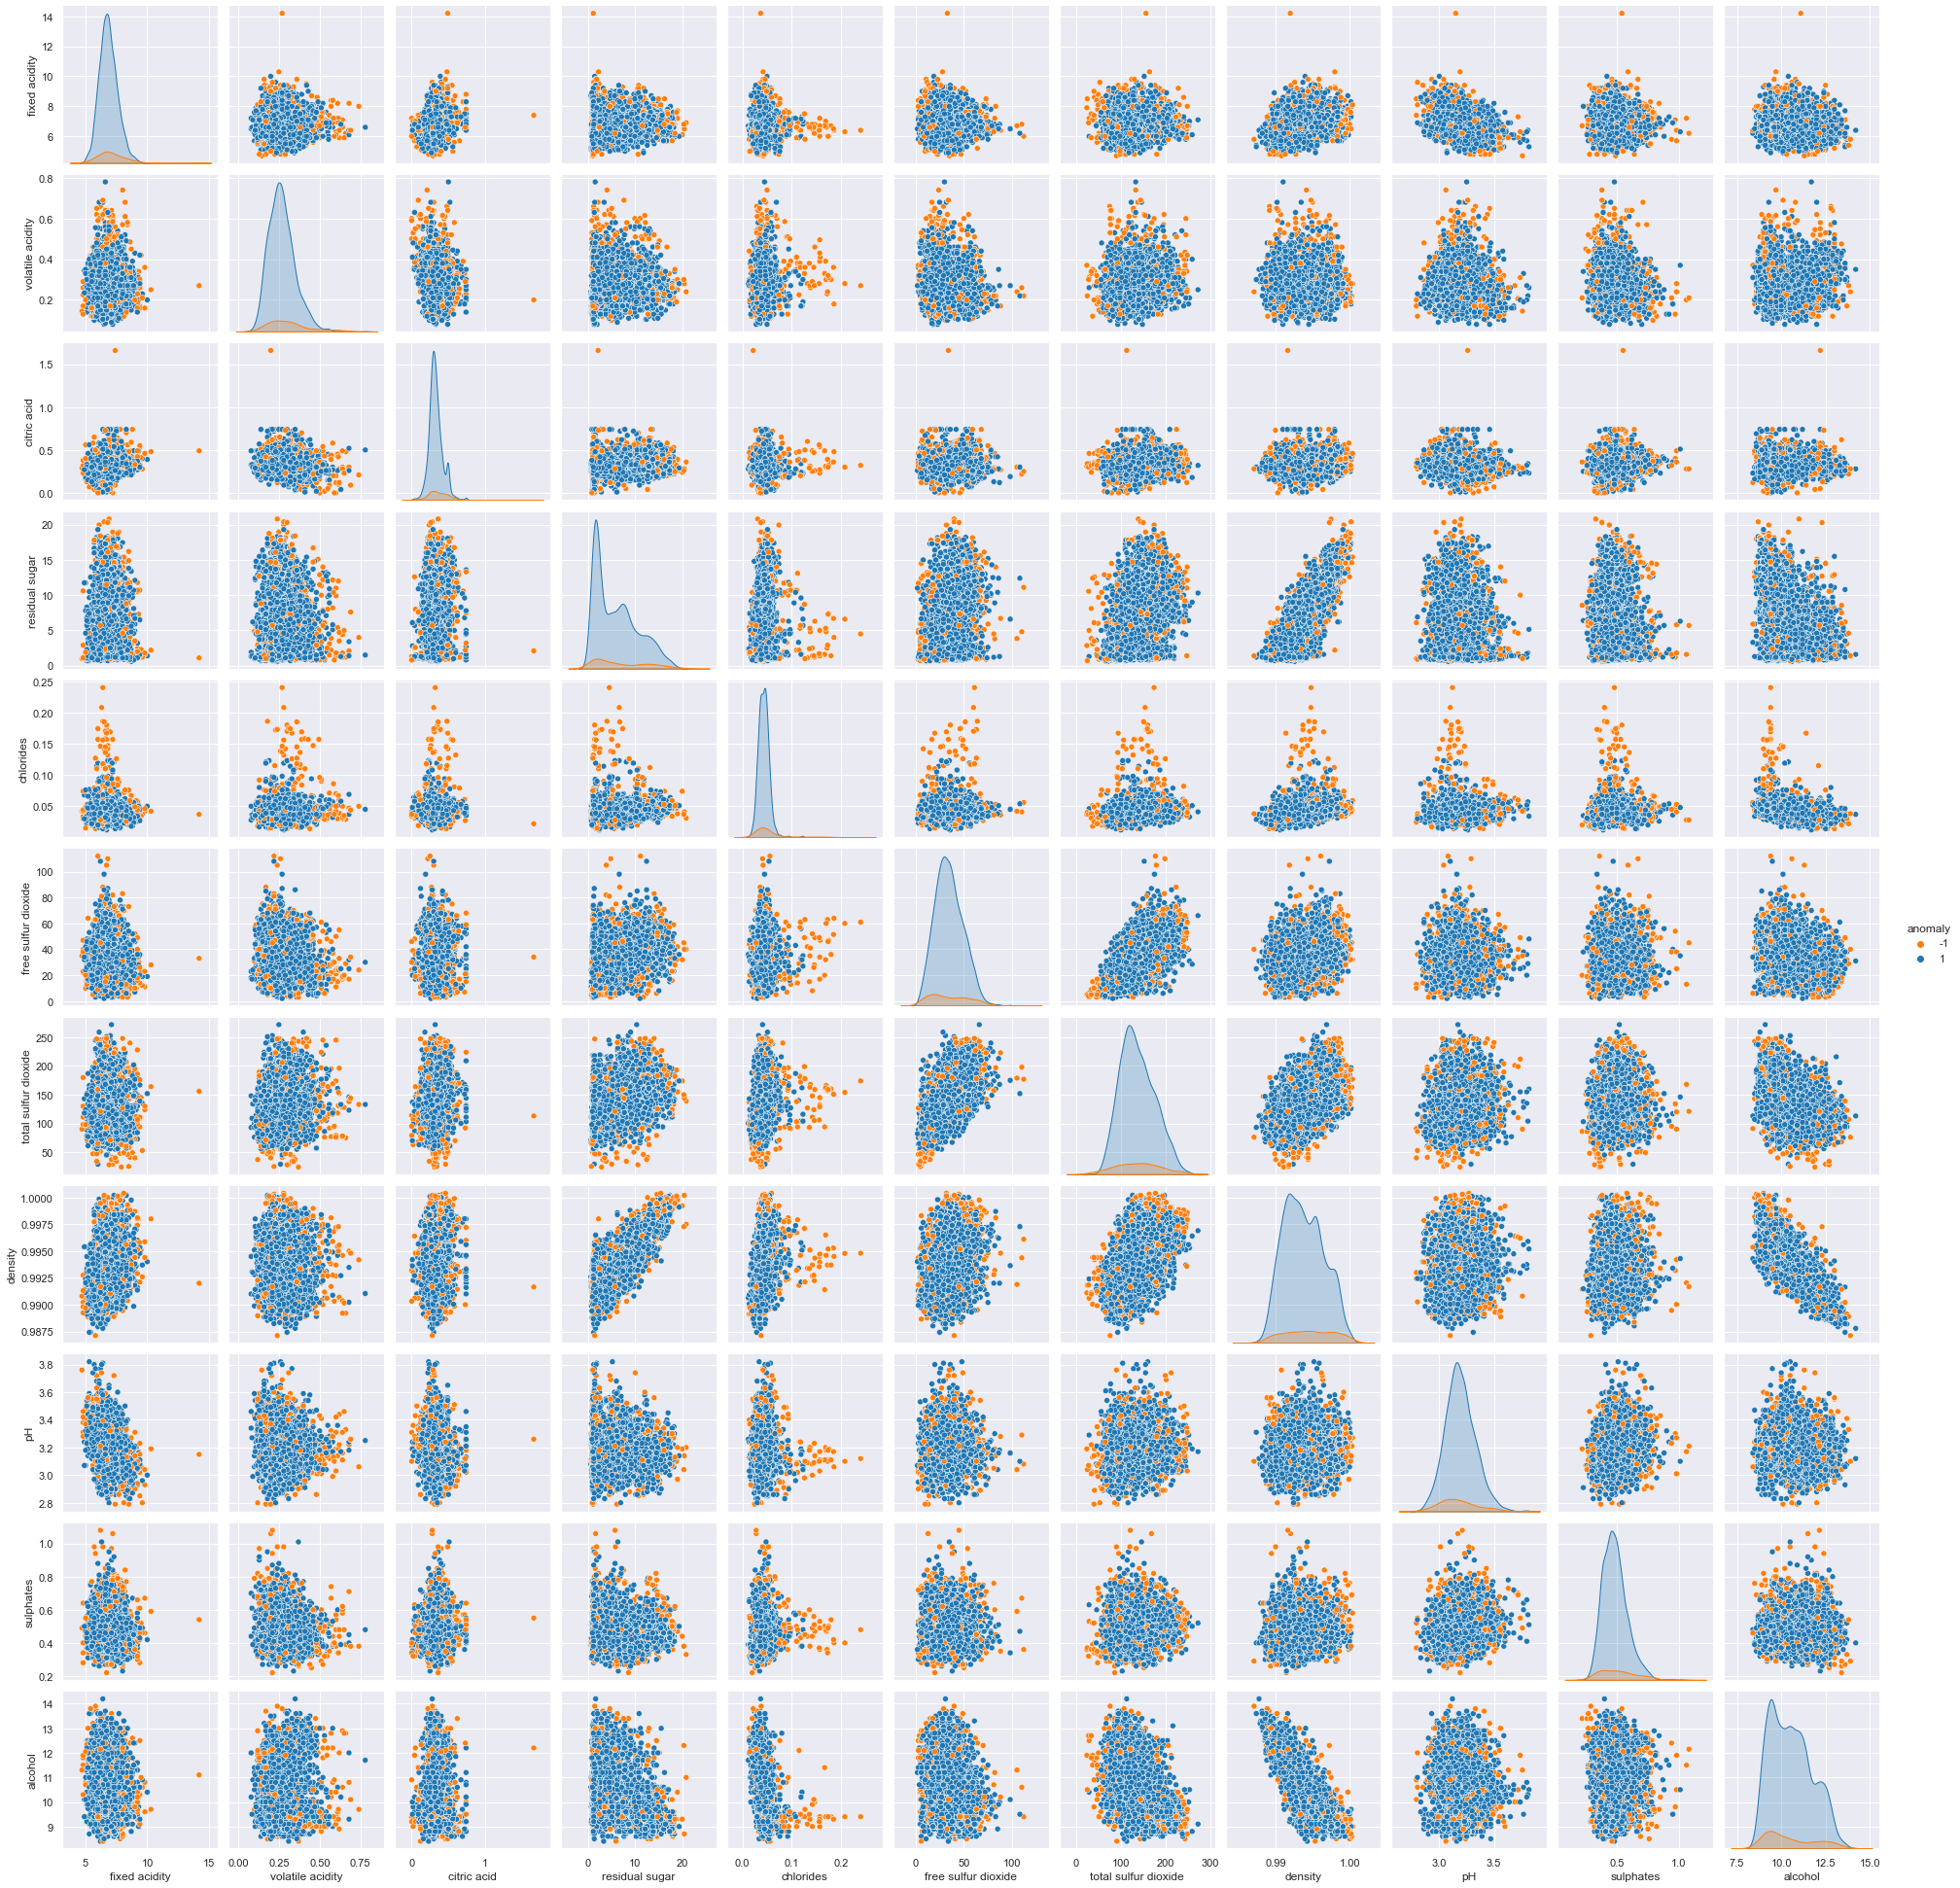

In [157]:
palette = ['#ff7f0e', '#1f77b4']
sb.pairplot(wine_white, vars=anomaly_inputs, hue='anomaly', palette=palette)

### These graphs show how the outliers of white wine are identified for each variable with respect to another variable. The red points are the identified outliers.

{'bootstrap': False, 'contamination': 0.1, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 100, 'n_jobs': None, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Outlier Method: Isolation Forest
Number of anomalous values 144
Number of non anomalous values  1289
Total Number of Values: 1433


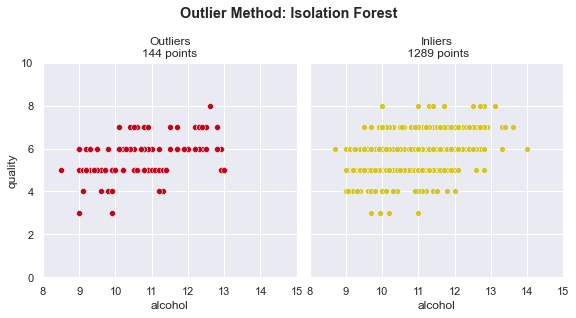

In [158]:
model.fit(wine_red[anomaly_inputs].values)
print(model.get_params())

wine_red['anomaly_scores'] = model.decision_function(wine_red[anomaly_inputs].values)
wine_red['anomaly'] = model.predict(wine_red[anomaly_inputs].values)
outlier_plot(wine_red, 'Isolation Forest', 'alcohol', 'quality', [8, 15], [0, 10]);

### The left plot shows the outliers removed from red wine dataframe.

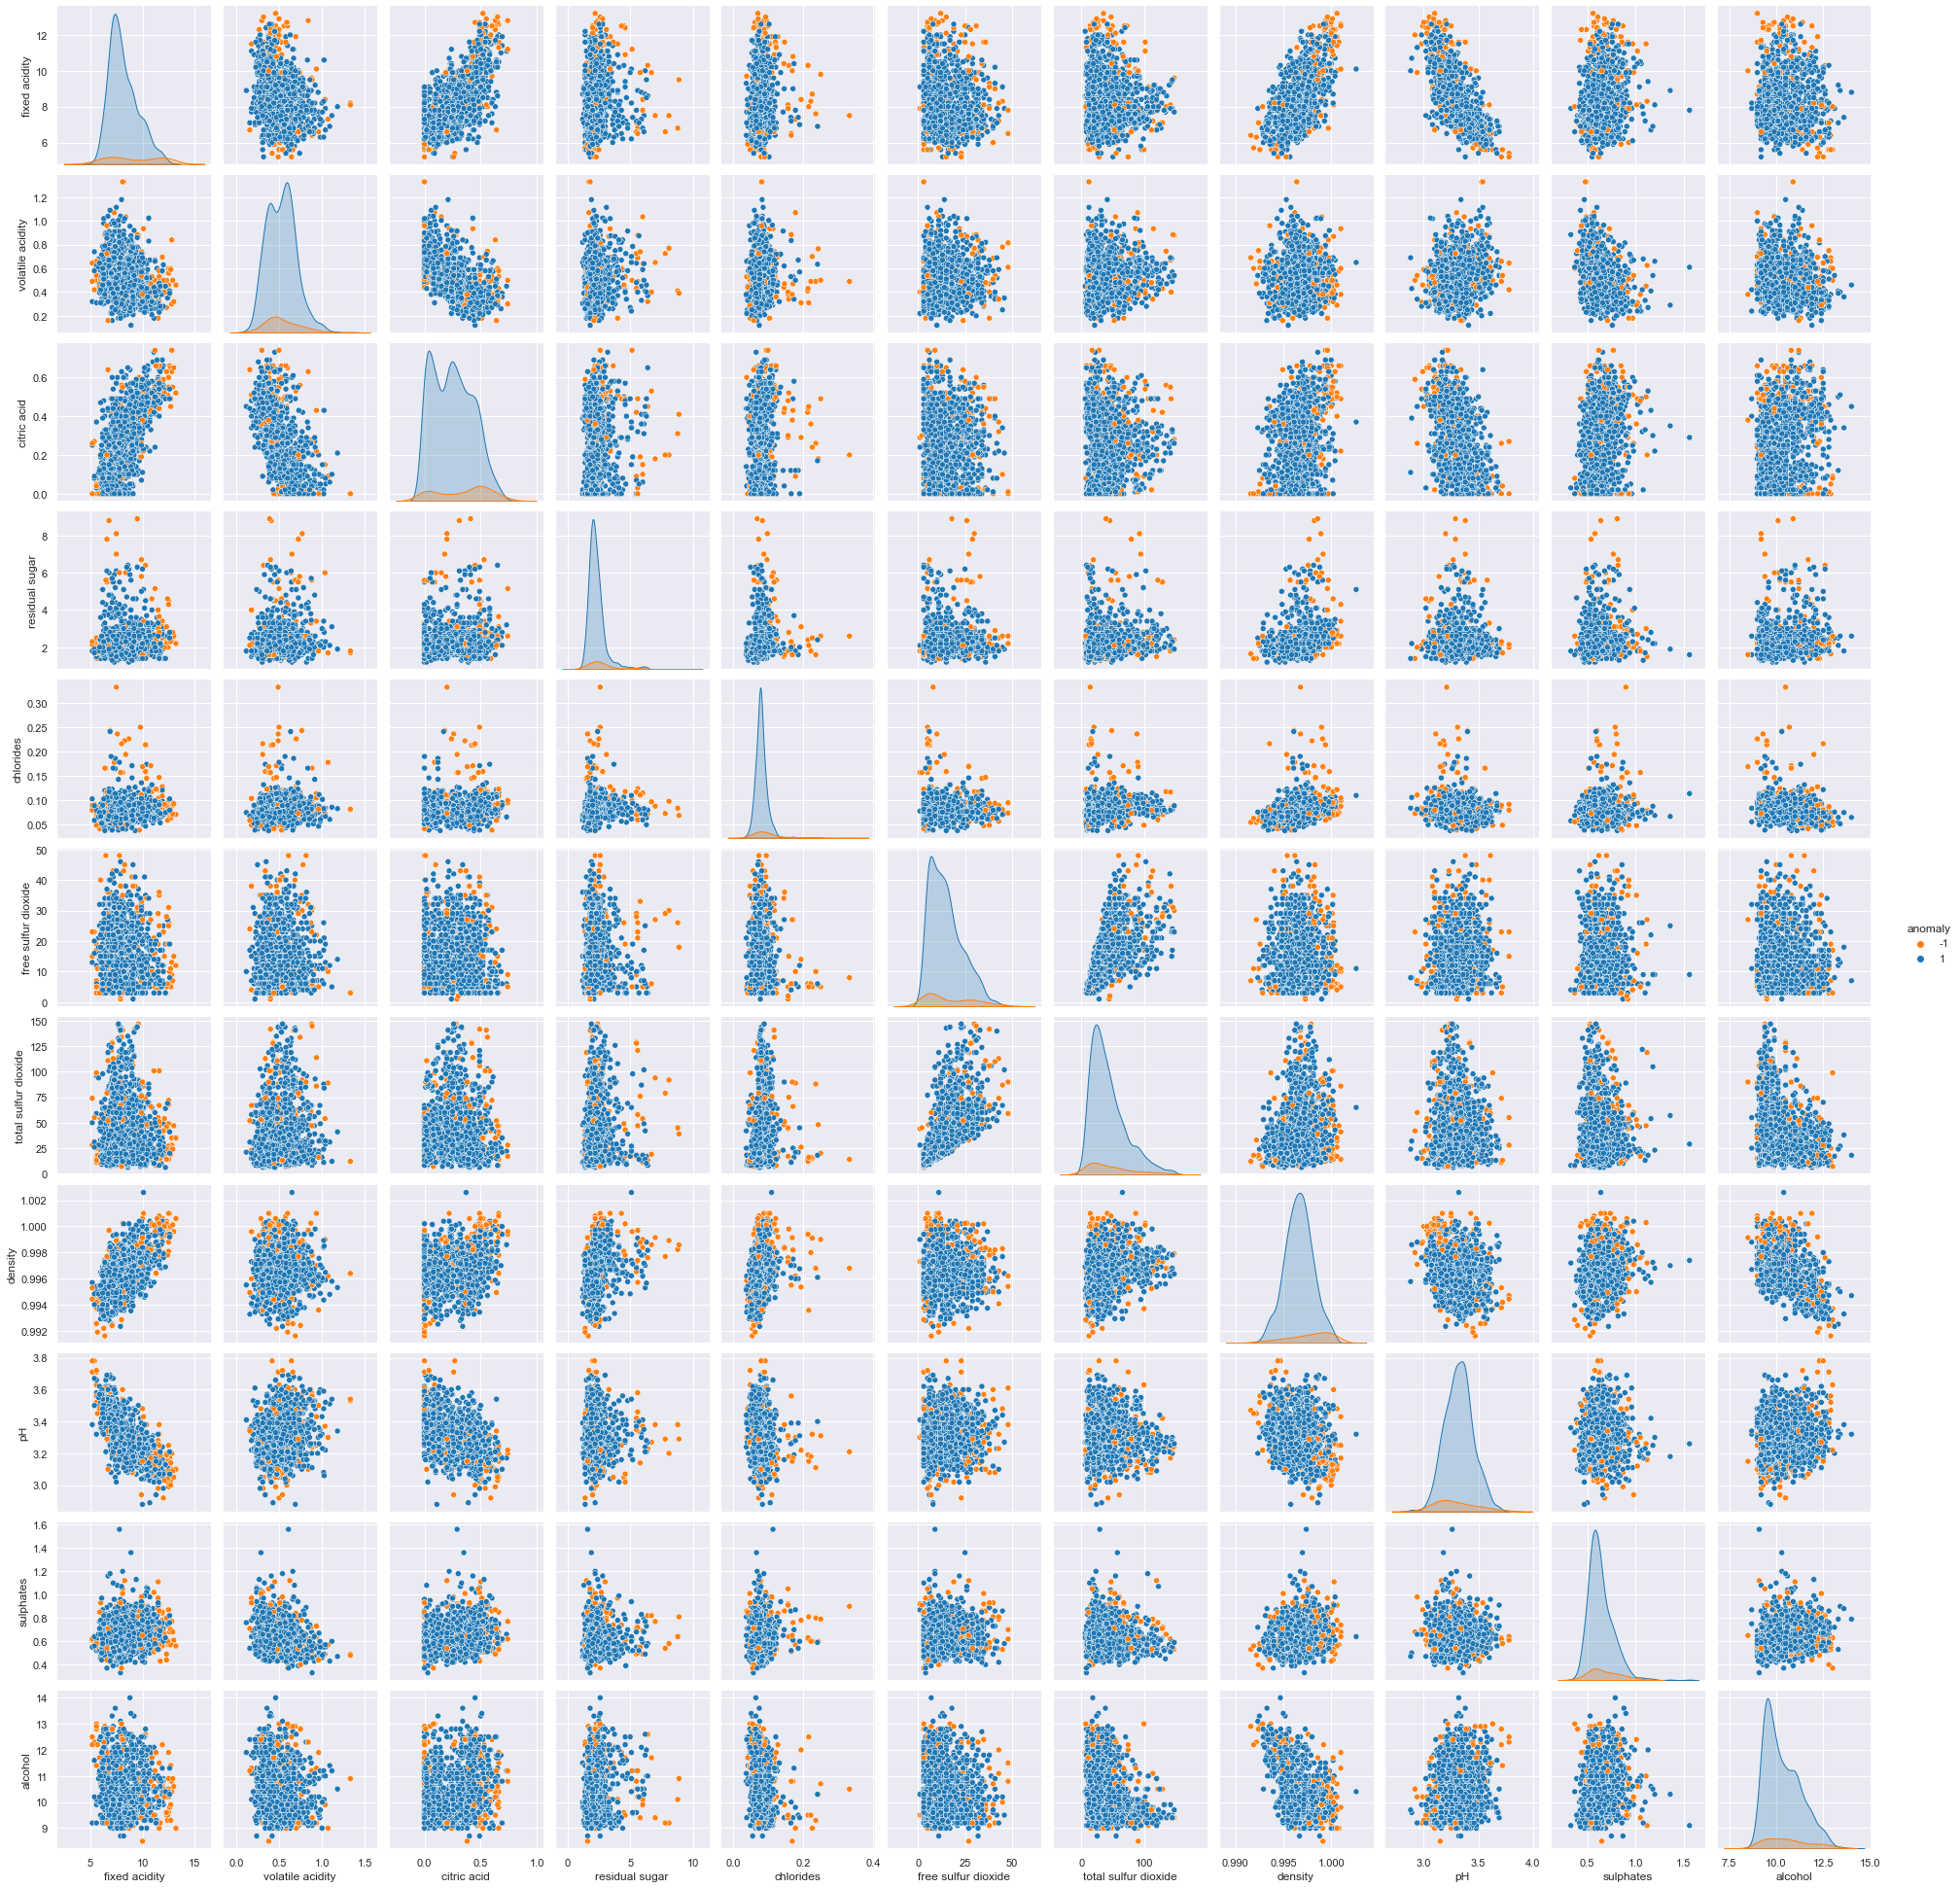

In [159]:
sb.pairplot(wine_red, vars=anomaly_inputs, hue='anomaly', palette=palette)

### These graphs show how the outliers of red wine are identified for each variable with respect to another variable. The red points are the identified outliers.

In [160]:
wine_combined = [wine_white, wine_red]
data = pd.concat(wine_combined)

In [161]:
data.head()

type  fixed acidity  volatile acidity  citric acid  residual sugar  \
1  white            6.3              0.30         0.34             1.6   
2  white            8.1              0.28         0.40             6.9   
3  white            7.2              0.23         0.32             8.5   
4  white            7.2              0.23         0.32             8.5   
5  white            8.1              0.28         0.40             6.9   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
1      0.049                 14.0                 132.0   0.9940  3.30   
2      0.050                 30.0                  97.0   0.9951  3.26   
3      0.058                 47.0                 186.0   0.9956  3.19   
4      0.058                 47.0                 186.0   0.9956  3.19   
5      0.050                 30.0                  97.0   0.9951  3.26   

   sulphates  alcohol  quality Quality Level  anomaly_scores  anomaly  
1       0.49      9.5        6        Medium        0.089188        1  
2       0.44     10.1        6        Medium        0.073773        1  
3       0.40      9.9        6        Medium        0.080275        1  
4       0.40      9.9        6        Medium        0.080275        1  
5       0.44     10.1        6        Medium        0.073773        1

In [162]:
data = data[data["anomaly"] == 1]

In [163]:
cleaned_df = data.drop(columns = ["anomaly_scores", "anomaly"])

---
## 5. Machine Learning Models

### Decision Tree

In [67]:
# Import essential models and functions from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Extract Response and Predictors
data = cleaned_df
predictors = ["type","fixed acidity", "volatile acidity", "citric acid", "residual sugar", "chlorides", "free sulfur dioxide", "total sulfur dioxide","density","pH","sulphates","alcohol"]
y = pd.DataFrame(data['quality'])
X = pd.DataFrame(data[predictors]) 
X['type'].replace(['white', 'red'],
                        [0, 1], inplace=True)

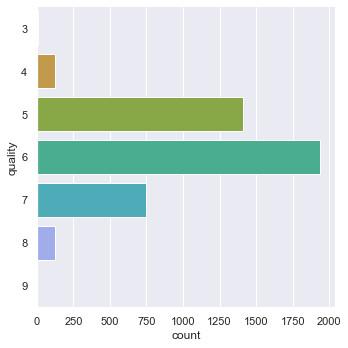

In [68]:
# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,stratify = y)

# Draw the distribution of Response
sb.catplot(y = "quality", data = y_train, kind = "count")

In [69]:
# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 4)  # create the decision tree object
dectree.fit(X_train, y_train)                    # train the decision tree model

# Predict Response corresponding to Predictors
y_train_pred = dectree.predict(X_train)
y_test_pred = dectree.predict(X_test)

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.5554791380100871

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.5429553264604811



<AxesSubplot:>

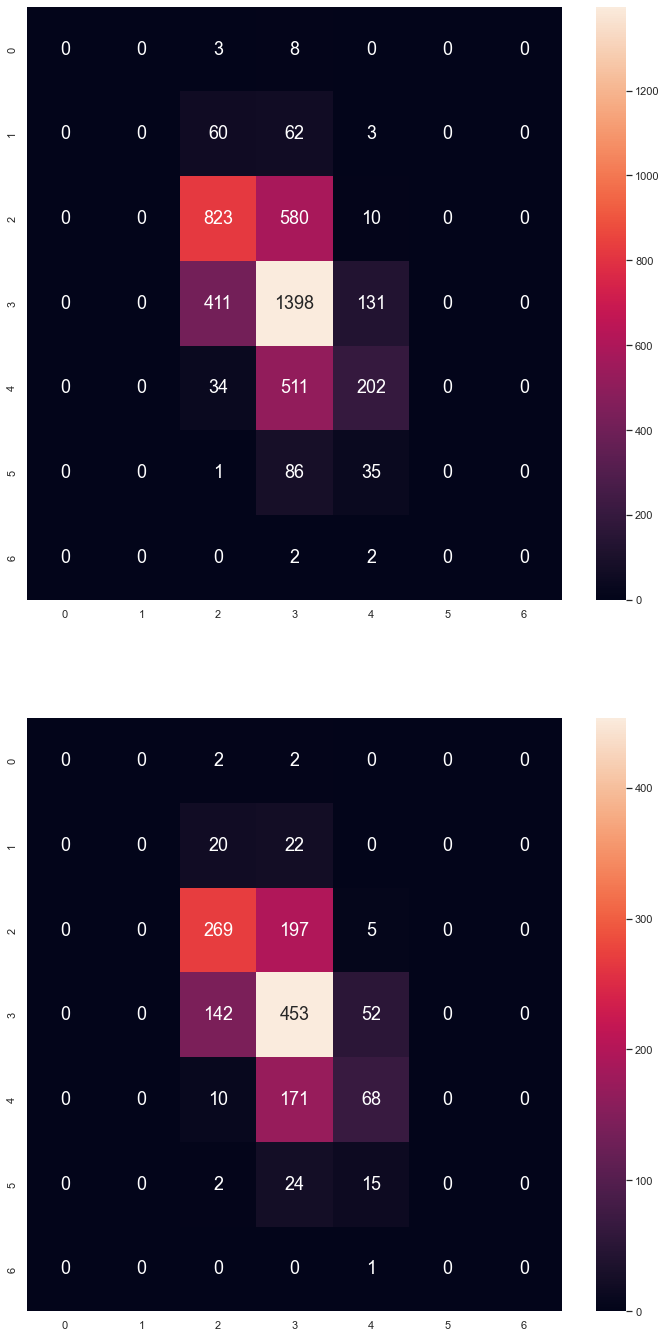

In [70]:
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(X_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree.score(X_test, y_test))
print()

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(2, 1, figsize=(12, 24))
sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

Root Mean Squared Error (RMSE) : 1.0439274329682446
R^2(train):  0.5554791380100871
R^2(test):  0.5429553264604811


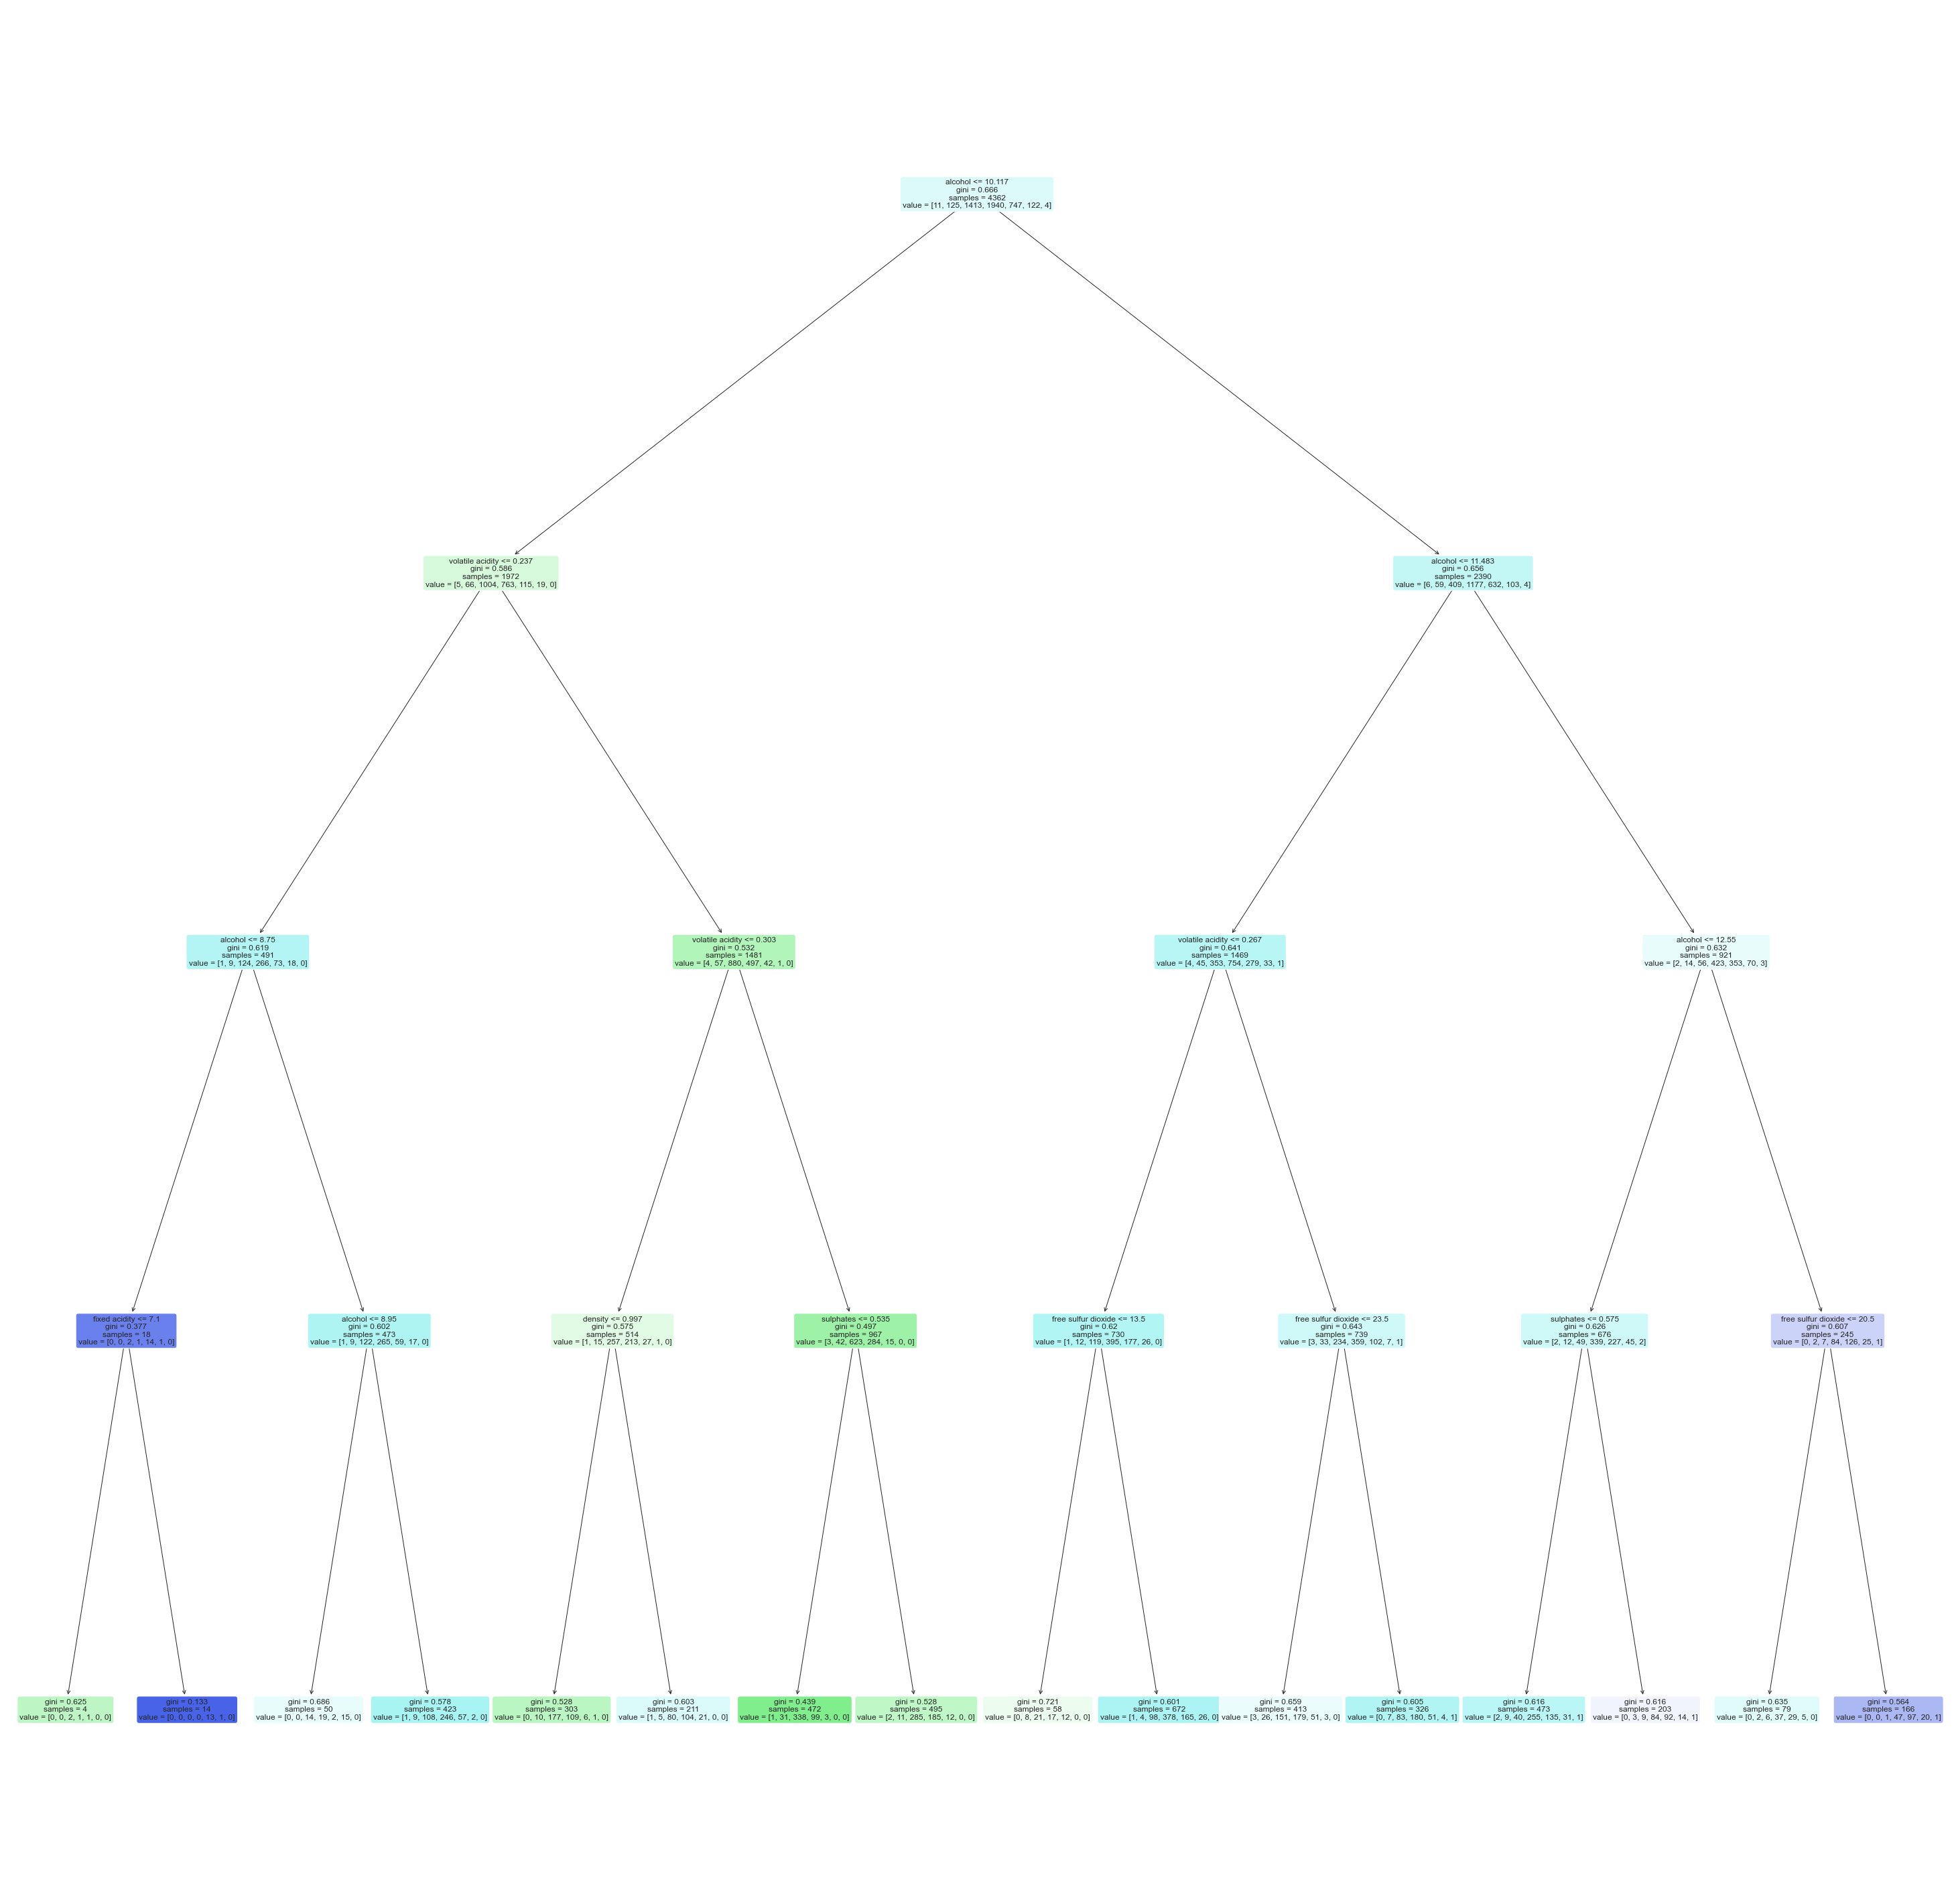

In [81]:
from sklearn.tree import plot_tree
from sklearn.metrics import mean_squared_error
f = plt.figure(figsize=(52,52))
plot_tree(dectree, 
          filled=True, 
          rounded=True,
          feature_names= X_test.columns,
          fontsize = 12)
mse = np.mean(np.square(np.array(y_test) - np.array(y_test_pred)))
rmse = np.sqrt(mse)

print("Root Mean Squared Error (RMSE) :", rmse)
print('R^2(train): ', dectree.score(X_train, y_train))
print('R^2(test): ', dectree.score(X_test, y_test))


In [1]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix

# Define the hyperparameters to tune using a parameter grid
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'min_samples_leaf': [1, 2, 3, 4],
    'criterion': ['gini', 'entropy']
}

# Define the decision tree classifier
tree = DecisionTreeClassifier()

# Define the grid search using 5-fold cross-validation
grid_search = GridSearchCV(tree, param_grid=param_grid, cv=5)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found by the grid search
print('Best hyperparameters: ', grid_search.best_params_)

# Use the best hyperparameters to train a new decision tree model
best_tree = DecisionTreeClassifier(**grid_search.best_params_)
best_tree.fit(X_train, y_train)

# Predict on the training and test sets using the best model
y_train_pred = best_tree.predict(X_train)
y_test_pred = best_tree.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", best_tree.score(X_train, y_train))
#print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", best_tree.score(X_test, y_test))
print()

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(2, 1, figsize=(12, 24))
sb.heatmap(confusion_matrix(y_train, y_train_pred),
            annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
            annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])
from sklearn.tree import plot_tree
f = plt.figure(figsize=(52,52))
plot_tree(best_tree, 
          filled=True, 
          rounded=True,
          feature_names= X_test.columns,
          fontsize = 12)

NameError: name 'GridSearchCV' is not defined

#### Decision tree doesn't work well since R^2 for train and test set are not high.

### LightGBM Model

- Light GBM is a fast, distributed, high-performance gradient boosting framework based on decision tree algorithm, used for ranking, classification and many other machine learning tasks.

In [82]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
import datetime
import time
from sklearn.metrics import mean_squared_error

ModuleNotFoundError: No module named 'lightgbm'

In [127]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size = 0.2, random_state = 42, shuffle = False)
X = train.drop(['quality'],axis = 1) #The Physicochemical Variables
X['type'].replace(['white', 'red'],[0, 1], inplace=True)
test['type'].replace(['white', 'red'],[0, 1], inplace=True)

y = train['quality']  #Target 
pv = [c for c in X.columns]  #The Physicochemical Variables
fidata = pd.DataFrame()  #create a data frame to store the physicochemical varialbles and it's feature_importance
predictions = np.zeros(len(test))
start = time.time()
oof = np.zeros(len(X))

In [128]:

# Define the Stratified K-Fold cross-validator with 5 folds
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#Set the the hyperparameters of the LightGBM model
param = {'num_leavs' : 111,
         'min_data_in_leaf' : 149,
         'objective' : 'regression',
         'max_depth' : 9,
         'learning_rate' : 0.005,
         'boosting' : 'gbdt',
         'feature_fraction' : 0.7522,
         'bagging_freq' : 1,
         'bagging_fraction' : 0.7083,
         'bagging_seed' : 11,
         'metric' : 'rmse',
         'lambda_l1' : 0.2634,
         'random_state' : 133,
         'verbosity' : -1
        }
#Iterate through each folds
for kfold, (trn_idx, val_idx) in enumerate(kfold.split(X.values, y.values)):
    print("fold n°{}".format(kfold))
    trn_data = lgb.Dataset(X.iloc[trn_idx][pv],label=y.iloc[trn_idx])#split train data
    val_data = lgb.Dataset(X.iloc[val_idx][pv],label=y.iloc[val_idx])#split validation data
    num_round = 10000
    clf = lgb.train(param,trn_data,num_round,valid_sets = [trn_data, val_data],verbose_eval=100,early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(X.iloc[val_idx][pv], num_iteration=clf.best_iteration)
    
    fidata = pd.DataFrame()
    fidata["feature"] = pv
    fidata["importance"] = clf.feature_importance()
    fidata["fold"] = kfold + 1
    
    predictions += clf.predict(test[pv], num_iteration=clf.best_iteration) / 5

print("CV score: {:<8.5f}".format(mean_squared_error(oof, y)**0.5))
   

fold n°0
[LightGBM] [Warning] Unknown parameter: num_leavs
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.775259	valid_1's rmse: 0.789565
[200]	training's rmse: 0.729377	valid_1's rmse: 0.752054
[300]	training's rmse: 0.70282	valid_1's rmse: 0.731469
[400]	training's rmse: 0.685692	valid_1's rmse: 0.718879
[500]	training's rmse: 0.673373	valid_1's rmse: 0.710336
[600]	training's rmse: 0.663816	valid_1's rmse: 0.704175
[700]	training's rmse: 0.655944	valid_1's rmse: 0.699375
[800]	training's rmse: 0.649281	valid_1's rmse: 0.696064
[900]	training's rmse: 0.643239	valid_1's rmse: 0.693299
[1000]	training's rmse: 0.637879	valid_1's rmse: 0.690945
[1100]	training's rmse: 0.63298	valid_1's rmse: 0.688751
[1200]	training's rmse: 0.62834	valid_1's rmse: 0.687071
[1300]	training's rmse: 0.623916	valid_1's rmse: 0.685296
[1400]	

[3400]	training's rmse: 0.557563	valid_1's rmse: 0.665571
[3500]	training's rmse: 0.55515	valid_1's rmse: 0.665049
[3600]	training's rmse: 0.55273	valid_1's rmse: 0.664767
[3700]	training's rmse: 0.550353	valid_1's rmse: 0.66445
[3800]	training's rmse: 0.548041	valid_1's rmse: 0.663911
[3900]	training's rmse: 0.54573	valid_1's rmse: 0.663528
[4000]	training's rmse: 0.543436	valid_1's rmse: 0.66334
[4100]	training's rmse: 0.541218	valid_1's rmse: 0.662944
[4200]	training's rmse: 0.539003	valid_1's rmse: 0.662537
[4300]	training's rmse: 0.536795	valid_1's rmse: 0.662072
[4400]	training's rmse: 0.534632	valid_1's rmse: 0.661612
[4500]	training's rmse: 0.532567	valid_1's rmse: 0.661203
[4600]	training's rmse: 0.530509	valid_1's rmse: 0.661008
[4700]	training's rmse: 0.528433	valid_1's rmse: 0.660633
[4800]	training's rmse: 0.52637	valid_1's rmse: 0.660427
[4900]	training's rmse: 0.524347	valid_1's rmse: 0.659897
[5000]	training's rmse: 0.522408	valid_1's rmse: 0.659648
[5100]	training's rm

[7400]	training's rmse: 0.484482	valid_1's rmse: 0.626756
[7500]	training's rmse: 0.482862	valid_1's rmse: 0.626397
[7600]	training's rmse: 0.48134	valid_1's rmse: 0.626122
[7700]	training's rmse: 0.479783	valid_1's rmse: 0.625848
[7800]	training's rmse: 0.478263	valid_1's rmse: 0.625655
[7900]	training's rmse: 0.476716	valid_1's rmse: 0.625305
[8000]	training's rmse: 0.475257	valid_1's rmse: 0.625001
[8100]	training's rmse: 0.473763	valid_1's rmse: 0.624715
[8200]	training's rmse: 0.472293	valid_1's rmse: 0.624426
[8300]	training's rmse: 0.470819	valid_1's rmse: 0.624089
[8400]	training's rmse: 0.469378	valid_1's rmse: 0.623623
[8500]	training's rmse: 0.467928	valid_1's rmse: 0.62333
[8600]	training's rmse: 0.466541	valid_1's rmse: 0.623026
[8700]	training's rmse: 0.465108	valid_1's rmse: 0.622757
[8800]	training's rmse: 0.463665	valid_1's rmse: 0.622754
[8900]	training's rmse: 0.462271	valid_1's rmse: 0.622545
[9000]	training's rmse: 0.460942	valid_1's rmse: 0.622377
[9100]	training'

[700]	training's rmse: 0.655118	valid_1's rmse: 0.699737
[800]	training's rmse: 0.648368	valid_1's rmse: 0.697155
[900]	training's rmse: 0.642384	valid_1's rmse: 0.695003
[1000]	training's rmse: 0.63703	valid_1's rmse: 0.692922
[1100]	training's rmse: 0.632111	valid_1's rmse: 0.691441
[1200]	training's rmse: 0.627353	valid_1's rmse: 0.689925
[1300]	training's rmse: 0.622972	valid_1's rmse: 0.688635
[1400]	training's rmse: 0.61858	valid_1's rmse: 0.687288
[1500]	training's rmse: 0.614582	valid_1's rmse: 0.685886
[1600]	training's rmse: 0.61073	valid_1's rmse: 0.684605
[1700]	training's rmse: 0.607162	valid_1's rmse: 0.683695
[1800]	training's rmse: 0.603628	valid_1's rmse: 0.682741
[1900]	training's rmse: 0.599989	valid_1's rmse: 0.681753
[2000]	training's rmse: 0.596557	valid_1's rmse: 0.680954
[2100]	training's rmse: 0.593196	valid_1's rmse: 0.680286
[2200]	training's rmse: 0.589866	valid_1's rmse: 0.679529
[2300]	training's rmse: 0.586736	valid_1's rmse: 0.678603
[2400]	training's rm

In [129]:
print("Root Mean Squared Error (RMSE) 	: {}".format(mean_squared_error(predictions, test['quality'])**0.5))

Root Mean Squared Error (RMSE) 	: 0.6996216843865551


- Using LightGBM model, we obtain a higher accuracy in predicting the salary. Accurate prediction data will help insight analysis.
- Now we print the top 8 features having highest feature importance.

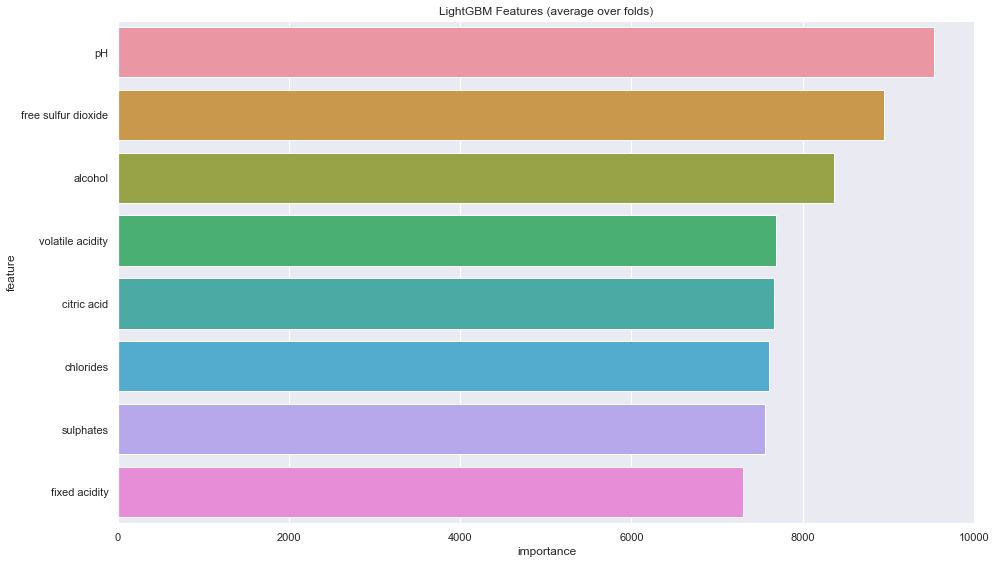

In [130]:
import seaborn as sns
cols = (fidata[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[3:11].index)

best_features = fidata.loc[fidata.feature.isin(cols)]

plt.figure(figsize=(14, 8))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (average over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

We find out the Top 8 features that influence wine quality most.
They are **`free sulfur diocide`**, **`pH`**, **`volatile acidity`**, **`sulphates`**, **`chlorides`**, **`alcohol`**, **`citric acid`**, **`fixed acidity`**.

Now we want to see that if our data cleaning is helpful for the machine learning model. So we do the LightGBM for uncleaned data set.

In [131]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(uncleaned_data, test_size = 0.2, random_state = 42, shuffle = False)
X = train.drop(['quality'],axis = 1) #The Physicochemical Variables
X['type'].replace(['white', 'red'],[0, 1], inplace=True)
test['type'].replace(['white', 'red'],[0, 1], inplace=True)

y = train['quality']  #Target 
pv = [c for c in X.columns]  #The Physicochemical Variables
fidata = pd.DataFrame()  #create a data frame to store the physicochemical varialbles and it's feature_importance
predictions = np.zeros(len(test))
start = time.time()
oof = np.zeros(len(X))

In [132]:
#Define the Stratified K-Fold cross-validator with 5 folds
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#Set the the hyperparameters of the LightGBM model
param = {'num_leavs' : 111,
         'min_data_in_leaf' : 149,
         'objective' : 'regression',
         'max_depth' : 9,
         'learning_rate' : 0.005,
         'boosting' : 'gbdt',
         'feature_fraction' : 0.7522,
         'bagging_freq' : 1,
         'bagging_fraction' : 0.7083,
         'bagging_seed' : 11,
         'metric' : 'rmse',
         'lambda_l1' : 0.2634,
         'random_state' : 133,
         'verbosity' : -1
        }
#Iterate through each folds
for kfold, (trn_idx, val_idx) in enumerate(kfold.split(X.values, y.values)):
    print("fold n°{}".format(kfold))
    trn_data = lgb.Dataset(X.iloc[trn_idx][pv],label=y.iloc[trn_idx])#split train data
    val_data = lgb.Dataset(X.iloc[val_idx][pv],label=y.iloc[val_idx])#split validation data
    num_round = 10000
    clf = lgb.train(param,trn_data,num_round,valid_sets = [trn_data, val_data],verbose_eval=100,early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(X.iloc[val_idx][pv], num_iteration=clf.best_iteration)
    
    fidata = pd.DataFrame()
    fidata["feature"] = pv
    fidata["importance"] = clf.feature_importance()
    fidata["fold"] = kfold + 1
    
    predictions += clf.predict(test[pv], num_iteration=clf.best_iteration) / 5

print("CV score: {:<8.5f}".format(mean_squared_error(oof, y)**0.5))
   

fold n°0
[LightGBM] [Warning] Unknown parameter: num_leavs
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.795052	valid_1's rmse: 0.800542
[200]	training's rmse: 0.74831	valid_1's rmse: 0.758472
[300]	training's rmse: 0.720966	valid_1's rmse: 0.733903
[400]	training's rmse: 0.703022	valid_1's rmse: 0.718179
[500]	training's rmse: 0.689851	valid_1's rmse: 0.707564
[600]	training's rmse: 0.679656	valid_1's rmse: 0.699345
[700]	training's rmse: 0.671078	valid_1's rmse: 0.693602
[800]	training's rmse: 0.663934	valid_1's rmse: 0.688996
[900]	training's rmse: 0.657648	valid_1's rmse: 0.685677
[1000]	training's rmse: 0.651686	valid_1's rmse: 0.682693
[1100]	training's rmse: 0.646383	valid_1's rmse: 0.680252
[1200]	training's rmse: 0.641418	valid_1's rmse: 0.67822
[1300]	training's rmse: 0.63667	valid_1's rmse: 0.676577
[1400]	

[3700]	training's rmse: 0.553268	valid_1's rmse: 0.683071
[3800]	training's rmse: 0.550816	valid_1's rmse: 0.682521
[3900]	training's rmse: 0.548441	valid_1's rmse: 0.681804
[4000]	training's rmse: 0.546133	valid_1's rmse: 0.68133
[4100]	training's rmse: 0.543834	valid_1's rmse: 0.680935
[4200]	training's rmse: 0.541487	valid_1's rmse: 0.680549
[4300]	training's rmse: 0.539215	valid_1's rmse: 0.68023
[4400]	training's rmse: 0.536997	valid_1's rmse: 0.679855
[4500]	training's rmse: 0.534743	valid_1's rmse: 0.67939
[4600]	training's rmse: 0.532572	valid_1's rmse: 0.678998
[4700]	training's rmse: 0.530429	valid_1's rmse: 0.678646
[4800]	training's rmse: 0.528328	valid_1's rmse: 0.678169
[4900]	training's rmse: 0.526285	valid_1's rmse: 0.677643
[5000]	training's rmse: 0.524134	valid_1's rmse: 0.677282
[5100]	training's rmse: 0.522118	valid_1's rmse: 0.676871
[5200]	training's rmse: 0.520146	valid_1's rmse: 0.676458
[5300]	training's rmse: 0.518196	valid_1's rmse: 0.67612
[5400]	training's 

[7500]	training's rmse: 0.483046	valid_1's rmse: 0.653422
[7600]	training's rmse: 0.481466	valid_1's rmse: 0.653368
[7700]	training's rmse: 0.479851	valid_1's rmse: 0.65336
[7800]	training's rmse: 0.478314	valid_1's rmse: 0.653072
[7900]	training's rmse: 0.47679	valid_1's rmse: 0.652982
[8000]	training's rmse: 0.475267	valid_1's rmse: 0.652809
[8100]	training's rmse: 0.473726	valid_1's rmse: 0.652541
[8200]	training's rmse: 0.472209	valid_1's rmse: 0.65237
[8300]	training's rmse: 0.470709	valid_1's rmse: 0.652148
[8400]	training's rmse: 0.469241	valid_1's rmse: 0.652077
[8500]	training's rmse: 0.467807	valid_1's rmse: 0.651761
[8600]	training's rmse: 0.466371	valid_1's rmse: 0.651487
[8700]	training's rmse: 0.464894	valid_1's rmse: 0.651336
[8800]	training's rmse: 0.46341	valid_1's rmse: 0.651228
[8900]	training's rmse: 0.46194	valid_1's rmse: 0.651135
[9000]	training's rmse: 0.460516	valid_1's rmse: 0.651106
[9100]	training's rmse: 0.459048	valid_1's rmse: 0.650908
[9200]	training's r

[1100]	training's rmse: 0.644322	valid_1's rmse: 0.689235
[1200]	training's rmse: 0.639428	valid_1's rmse: 0.687702
[1300]	training's rmse: 0.63481	valid_1's rmse: 0.686049
[1400]	training's rmse: 0.630508	valid_1's rmse: 0.684575
[1500]	training's rmse: 0.62632	valid_1's rmse: 0.683182
[1600]	training's rmse: 0.622333	valid_1's rmse: 0.681838
[1700]	training's rmse: 0.618477	valid_1's rmse: 0.680515
[1800]	training's rmse: 0.614806	valid_1's rmse: 0.679215
[1900]	training's rmse: 0.611285	valid_1's rmse: 0.678312
[2000]	training's rmse: 0.607738	valid_1's rmse: 0.677298
[2100]	training's rmse: 0.60434	valid_1's rmse: 0.676444
[2200]	training's rmse: 0.601054	valid_1's rmse: 0.675706
[2300]	training's rmse: 0.597791	valid_1's rmse: 0.674898
[2400]	training's rmse: 0.594515	valid_1's rmse: 0.67404
[2500]	training's rmse: 0.591438	valid_1's rmse: 0.673247
[2600]	training's rmse: 0.588382	valid_1's rmse: 0.672735
[2700]	training's rmse: 0.585315	valid_1's rmse: 0.67177
[2800]	training's r

In [133]:
print("Root Mean Squared Error (RMSE) 	: {}".format(mean_squared_error(predictions, test['quality'])**0.5))

Root Mean Squared Error (RMSE) 	: 0.7124607165503871


After data cleaning, the RMSE decrease from 0.7125 to 0.6996.